
**Exploratory data analysis (EDA) and initial text analysis:**



    - Distribution 
    - Analysis of `Title`: Worldcloud, Term Frequency
    - Analysis of `Star` : Barplot
    - Analysis of `Reviews Amount` : Barplot
    - Analysis of `Introduction` : TF-IDF
    - Analysis of `Description` : TF-IDF
    - Analysis of `About Author` : TF-IDF    
    - Analysis of `Price` : Barplot
    - Analysis of `Correction of Variables`
    - Analysis of `Reviews (example)` : Sentiment Mining


In [8]:
# Load the library
import csv
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
from nltk.tokenize import word_tokenize
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
import re 

In [10]:
# load the raw data
books=pd.read_csv("book_2clean.csv",header=0, index_col=0)
print(books.head())
print(books.info())

                                             book_link  \
No.                                                      
0    https://www.amazon.com/10-Day-Green-Smoothie-C...   
1    https://www.amazon.com/Simon-Schuster-Audio-Th...   
2    https://www.amazon.com/Wheat-Belly-Lose-Weight...   
3    https://www.amazon.com/Thug-Kitchen-Official-C...   
4    https://www.amazon.com/Medical-Medium-Secrets-...   

                                                 title  \
No.                                                      
0    10-Day Green Smoothie Cleanse: Lose Up to 15 P...   
1                                           The Secret   
2    Wheat Belly: Lose the Wheat, Lose the Weight, ...   
3    Thug Kitchen: The Official Cookbook: Eat Like ...   
4    Medical Medium: Secrets Behind Chronic and Mys...   

                                                author  star  review_amount  \
No.                                                                           
0                           

In [11]:
# check missing values
books.isnull().sum()

book_link            0
title                0
author               2
star                 0
review_amount        0
kindle_price       127
paperback_price    299
hardcover_price    528
intro                5
book_rank          121
product_desc       408
abt_author         802
key_words            0
dtype: int64

### Analysis of Title
The most popular words in title are 'Diet', 'Easy', 'Health', and 'Guide'. 

In [53]:
title=list(books["title"])
tokens=str(title).split()
tokens = [tokens.strip(string.punctuation).lower() for tokens in tokens]
tokens=[token.strip() for token in tokens if token.strip()!='']

stop_words = stopwords.words('english')
stop_words+=["cook", "cooking","cookbook","cooker","book","recipes","food"]
stop_words+=['•','’','“','--','–',"''",'—','”','``']
word_dist=nltk.FreqDist(tokens)
filtered_dict={word: word_dist[word] \
                     for word in word_dist \
                     if word not in stop_words}
sorted_dict = sorted(filtered_dict.items(), key=lambda x: x[1], reverse=True)
len(sorted_dict)

2518

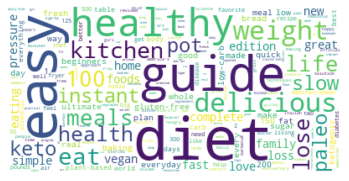

In [54]:
# Generate Wordcloud

text = open(u'title.txt','r').read()

# Display the generated image:

wordcloud = WordCloud(background_color="white",
                      stopwords=stop_words).generate_from_frequencies(filtered_dict);
plt.figure();
plt.imshow(wordcloud, interpolation="bilinear");
plt.axis("off");
plt.show();

* From the word cloud we can notice several striking words, which are "diet", "easy", "guide", "delicious", "healthy", "weight".
* This may be an early indication of consumer preferences: healthy, simple, slimming, easy-to-learn recipes.

In [55]:
import pandas as pd

# since we have a small corpus, we can use dataframe 
# to get document-term matrix
# but don't use this when you have a large corpus

dtm=pd.DataFrame.from_dict(filtered_dict, \
                           orient="index" )
dtm=dtm.fillna(0)
dtm
# convert dtm to numpy arrays
tf=dtm.values

# sum the value of each row
doc_len=tf.sum(axis=1)

# divide dtm matrix by the doc length matrix
tf=np.divide(tf, doc_len[:,None])


IDF Matrix
[0.10996984]

Smoothed IDF Matrix
[0.11053943]


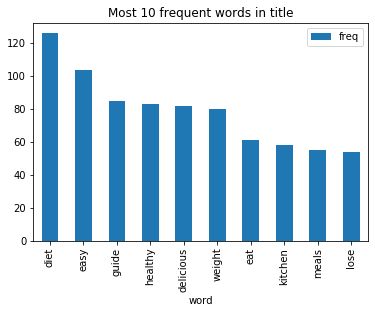

In [56]:
# get document freqent
df=np.where(tf>0,1,0)

# get idf
idf=np.log(np.divide(len(title), \
        np.sum(df, axis=0)))+1
print("\nIDF Matrix")
print (idf)

smoothed_idf=np.log(np.divide(len(title)+1, np.sum(df, axis=0)+1))+1
print("\nSmoothed IDF Matrix")
print(smoothed_idf)

word_freq=pd.DataFrame(sorted_dict,columns=['word','freq'])
word_freq[:10].plot(kind='bar',x='word',y='freq',
                   title='Most 10 frequent words in title')
plt.show()

### Analysis of Star (rating)
Average of star is 4.5

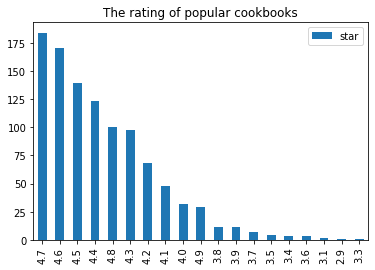

In [15]:
star_count=pd.DataFrame(books['star'].value_counts())
star_count.plot(kind='bar',
                title='The rating of popular cookbooks')

### Analysis of Review_amount
Average of review amount is 550.9 and almost in 200~400

Review Amount Average 550.9
            count
0~200           0
200~400       567
400~600       195
600~800       121
800~1000       41
above 1000    110


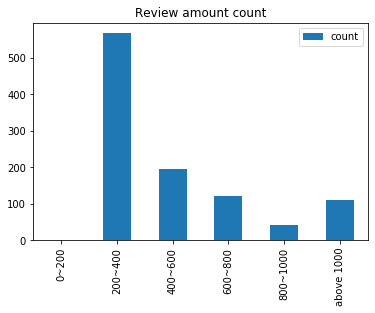

In [38]:
reviews_amount=books['review_amount']
# reviews_amount.plot(kind='line')
# print(min(reviews_amount))
# bins = [min(books.review_amount)-1, 200, 400, 600, 800, 1000, max(books.review_amount)+1]
# books['cut'] = pd.cut(books.review_amount, bins)
# print(books['cut'])


review_amount_avg = np.mean(books["review_amount"])
print("Review Amount Average",round(review_amount_avg,1))
ind = np.digitize(reviews_amount,[200, 400, 600, 800, 1000]) 
a = np.bincount(ind)
b = pd.DataFrame(a, index=['0~200','200~400','400~600','600~800','800~1000','above 1000'])
new_col = ['count']
b.columns = new_col
b.plot(kind='bar', title='Review amount count')
print(b)


### Analysis of Intro
The most freqent words in Intro are 'Diet', 'Keto', 'Instant', 'Paleo', 'Slow'

In [40]:
def get_doc_tokens(doc):
    tokens=[token.strip() \
            for token in nltk.word_tokenize(doc.lower()) \
            if token.strip() not in stop_words and\
               token.strip() not in string.punctuation]
    
    # you can add bigrams, collocations, or lemmatization here
    
    # create token count dictionary
    token_count={token:tokens.count(token) for token in set(tokens)}
    
    return token_count

def tfidf(docs):
    # step 2. process all documents to get list of token list
    docs_tokens={idx:get_doc_tokens(doc) \
             for idx,doc in enumerate(docs)}

    # step 3. get document-term matrix
    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm=dtm.fillna(0)
      
    # step 4. get normalized term frequency (tf) matrix        
    tf=dtm.values
    doc_len=tf.sum(axis=1)
    tf=np.divide(tf.T, doc_len).T
    
    # step 5. get idf
    df=np.where(tf>0,1,0)
    #idf=np.log(np.divide(len(docs), \
    #    np.sum(df, axis=0)))+1

    smoothed_idf=np.log(np.divide(len(docs)+1, np.sum(df, axis=0)+1))+1    
    smoothed_tf_idf=tf*smoothed_idf
    
    top=smoothed_tf_idf.argsort()[:,::-1][:,0:5] #"-1" reverse the order of columns
    #print(top)
    top_intro=[]
    for row in top:
        t=[dtm.columns[x] for x in row]
        top_intro.append(t)
        
    return smoothed_tf_idf, top_intro


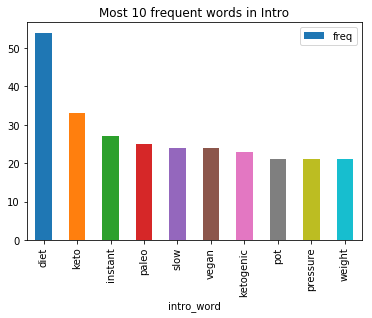

In [0]:
# drop missing values of 'intro' column
# translate 'intro' from series to list of strings
# get smoothed_tf_idf and top 5 words in each intro
intro=list(books['intro'].dropna().astype(str).str.replace('\n', ''))
smoothed_tf_idf,top_intro=tfidf(intro)

# sort top 10 words in all the intros from top_intro
tokens=str(top_intro).split()
tokens = [tokens.strip(string.punctuation).lower() for tokens in tokens]
tokens=[token.strip() for token in tokens if token.strip()!='']
word_dist=nltk.FreqDist(tokens)
filtered_dict={word: word_dist[word] \
                     for word in word_dist \
                     if word not in stop_words}
sorted_dict = sorted(filtered_dict.items(), key=lambda x: x[1], reverse=True)

# plot the most 10 frequent words in intro
intro_freq=pd.DataFrame(sorted_dict,columns=['intro_word','freq'])
intro_freq[:10].plot(kind='bar',x='intro_word',y='freq',
                     title='Most 10 frequent words in Intro')
plt.show()

### Analysis of product_desc
The most freqent words in Product description are 'Vergan' 'Diet','Paleo','Health', 'Dr'

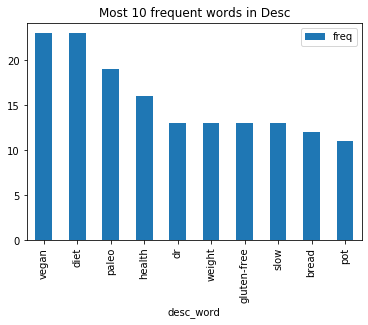

In [41]:
# drop missing values of 'product_desc' column
# translate 'product_desc' from series to list of strings
# get smoothed_tf_idf and top 5 words in each product_desc

product_desc=list(books['product_desc'].dropna().astype(str).str.replace('\n', ''))
smoothed_tf_idf,top_desc=tfidf(product_desc)

# sort top 10 words in all the intros from top_desc
tokens=str(top_desc).split()
tokens = [tokens.strip(string.punctuation).lower() for tokens in tokens]
tokens=[token.strip() for token in tokens if token.strip()!='']
word_dist=nltk.FreqDist(tokens)
filtered_dict={word: word_dist[word] \
                     for word in word_dist \
                     if word not in stop_words}
sorted_dict = sorted(filtered_dict.items(), key=lambda x: x[1], reverse=True)

# plot the most 10 frequent words in product_desc
intro_freq=pd.DataFrame(sorted_dict,columns=['desc_word','freq'])
intro_freq[:10].plot(kind='bar',x='desc_word',y='freq',
                     title='Most 10 frequent words in Desc')
plt.show()

### Analysis of abt_author
The most freqent words in about author are 'Test' 'Kitchen','Television','AuthorAmerica', 'Recohnization'

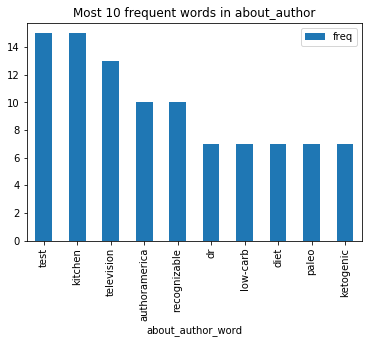

In [43]:
# drop missing values of 'abt_author' column
# translate 'abt_author' from series to list of strings
# get smoothed_tf_idf and top 5 words in each abt_author

abt_author=list(books['abt_author'].dropna().astype(str).str.replace('\n', ''))
smoothed_tf_idf,top_aut=tfidf(abt_author)

# sort top 10 words in all the intros from top_aut
tokens=str(top_aut).split()
tokens = [tokens.strip(string.punctuation).lower() for tokens in tokens]
tokens=[token.strip() for token in tokens if token.strip()!='']
word_dist=nltk.FreqDist(tokens)
filtered_dict={word: word_dist[word] \
                     for word in word_dist \
                     if word not in stop_words}
sorted_dict = sorted(filtered_dict.items(), key=lambda x: x[1], reverse=True)

# plot the most 10 frequent words in abt_author
intro_freq=pd.DataFrame(sorted_dict,columns=['about_author_word','freq'])
intro_freq[:10].plot(kind='bar',x='about_author_word',y='freq',
                     title='Most 10 frequent words in about_author')
plt.show()

### Analysis of price
Hardcover is most expensive than paperback and kindle

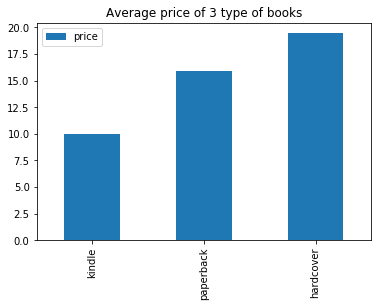

In [45]:
# replace nan values with average of columns

kindle_price_avg = np.nanmean(books["kindle_price"])
paperback_price_avg = np.nanmean(books["paperback_price"])
hardcover_price_avg = np.nanmean(books["hardcover_price"])

price = pd.DataFrame([kindle_price_avg,paperback_price_avg,hardcover_price_avg],index=['kindle','paperback','hardcover'])
new_col = ['price']
price.columns = new_col

# plot the Average price of 3 type of books
price.plot(kind='bar', title='Average price of 3 type of books')

### Analysis correction of variables
Positive correlation include: (hardcover_price,star), (kindle_price,star), (hardcover_price,kindle_price)
Negative correlation include: (book_rank,star), (book_rank,review_amount)

[Text(0.5, 0, 'star'),
 Text(1.5, 0, 'review_amount'),
 Text(2.5, 0, 'kindle_price'),
 Text(3.5, 0, 'paperback_price'),
 Text(4.5, 0, 'hardcover_price'),
 Text(5.5, 0, 'book_rank')]

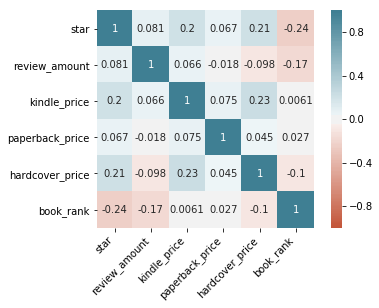

In [0]:
data1 = books[["star","review_amount","kindle_price","paperback_price","hardcover_price","book_rank"]]
corr = data1.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True,
    cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')